### Задание №1.
Сгенерировать датасет при помощи `sklearn.datasets.make_regression` и обучить линейную модель при помощи градиентного спуска и  стохастического градиентного спуска. Построить графики среднеквадратичной ошибки от числа итераций для обоих методов на одном рисунке, сделать выводы о разнице скорости сходимости каждого из методов.

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14,
                     'xtick.labelsize': 14})
%matplotlib inline

In [2]:
X_, y_, coef = datasets.make_regression(n_samples=10000, n_features=2, n_informative=2, n_targets=1, 
                                      noise=5, coef=True, random_state=23)

In [3]:
def calc_mse(y, y_pred):
    return np.mean((y - y_pred) ** 2)

In [4]:
def eval_gd(X, y, iters=1000, alpha=1e-3, random_state=None, verbose=False):
    if random_state:
        np.random.seed(random_state)
    
    w = np.random.randn(X.shape[1])
    y_pred = np.dot(X, w)
    n = X.shape[0]
    
    for i in range(1, iters + 1):
        w -= alpha * 2 * np.dot(X.T, y_pred - y) / n
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        
        if verbose and i % (iters / 10) == 0:
            print(i, w, err)
    
    return w

In [5]:
def eval_sgd(X, y, iters=1000, alpha=1e-3, random_state=None, verbose=False):
    if random_state:
        np.random.seed(random_state)
    
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    
    for i in range(1, iters + 1):
        ind = np.random.randint(n)
        y_pred = np.dot(X[ind], w)
        w -= alpha * 2 * np.dot(y_pred - y[ind], X[ind])
        
        err = calc_mse(y, np.dot(X, w))
        
        if verbose and i % (iters / 10) == 0:
            print(i, w, err)
    
    return w

In [6]:
def eval_mbgd(X, y, iters=200, alpha=1e-3, batch=None, random_state=None, verbose=False):
    if random_state:
        np.random.seed(random_state)
    
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    batch = batch if batch else n
    n_batch = n // batch if n % batch == 0 else n // batch + 1
    
    for i in range(1, iters + 1):
        
        for b in range(n_batch):
            start_ = b * batch
            end_ = (b + 1) * batch
            y_pred = np.dot(X[start_ : end_, :], w)
            w -= alpha * 2 * np.dot(y_pred - y[start_ : end_], X[start_ : end_, :]) / batch
        
        err = calc_mse(y, np.dot(X, w))
        
        if verbose and i % (iters / 10) == 0:
            print(i, w, err)
    
    return w

In [7]:
iter_arr_1 = np.linspace(500, 1800, 21)
mse_gd_arr = np.array([calc_mse(y_, np.dot(X_, eval_gd(X_, y_, iters=int(i), alpha=1e-3, random_state=23))) for i in iter_arr_1])
mse_sgd_arr = np.array([calc_mse(y_, np.dot(X_, eval_sgd(X_, y_, iters=int(i), alpha=1e-3, random_state=23))) for i in iter_arr_1])

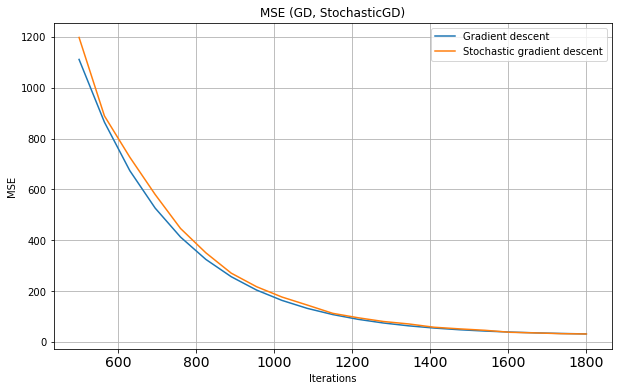

In [8]:
plt.figure(figsize=(10, 6))

plt.plot(iter_arr_1, mse_gd_arr, label='Gradient descent')
plt.plot(iter_arr_1, mse_sgd_arr, label='Stochastic gradient descent')
plt.title('MSE (GD, StochasticGD)')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.grid()
plt.show()

Зависимости среднеквадратичной ошибки от количества итераций в случаях градиентного спуска и стохастического градиентного спуска практически идентичны, и сходятся алгоритмы практически при одинаковых количествах итераций (в данном случае после 1500 итераций, при $\alpha = 2\cdot10^{-3}$). Но, как можно увидеть ниже, так как одна итерация стохастического градиентного спуска быстрее обычного полного, суммарно при обучении модели на датасете в 10000 обьектов при прочих равных условиях скорость первого метода в 1,5 - 2 раза выше второго.

In [9]:
weights_gd_arr = np.array([eval_gd(X_, y_, alpha=2e-3, iters=int(i), random_state=23) for i in iter_arr_1])
weights_sgd_arr = np.array([eval_sgd(X_, y_, alpha=2e-3, iters=int(i), random_state=23) for i in iter_arr_1])

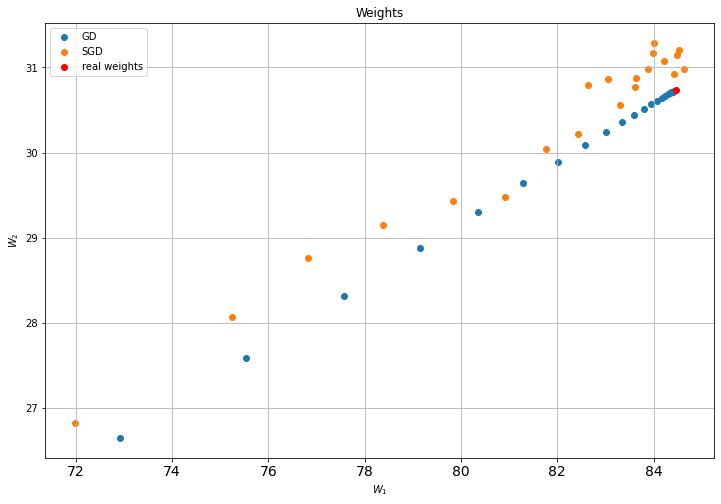

In [10]:
plt.figure(figsize=(12, 8))
plt.scatter(weights_gd_arr[:, 0], weights_gd_arr[:, 1], label='GD')
plt.scatter(weights_sgd_arr[:, 0], weights_sgd_arr[:, 1], label='SGD')
plt.scatter(coef[0], coef[1], c='r', label='real weights')
plt.title('Weights')
plt.ylabel(r'$W_2$')
plt.xlabel(r'$W_1$')
plt.legend()
plt.grid()
plt.show()

Как можно было ожидать, веса стохастического метода приближаются к реальным хаотично в отличии от полного градиентного спуска, где коэффициенты целенаправленно стремятся к реальным.

In [11]:
iter_arr_2 = np.linspace(10, 160, 16)
mse_mbgd_arr_100 = np.array([calc_mse(y_, np.dot(X_, eval_mbgd(X_, y_, iters=int(i), batch=100, random_state=23))) for i in iter_arr_2])
mse_mbgd_arr_500 = np.array([calc_mse(y_, np.dot(X_, eval_mbgd(X_, y_, iters=int(i), batch=500, random_state=23))) for i in iter_arr_2])
mse_mbgd_arr_1000 = np.array([calc_mse(y_, np.dot(X_, eval_mbgd(X_, y_, iters=int(i), batch=1000, random_state=23))) for i in iter_arr_2])

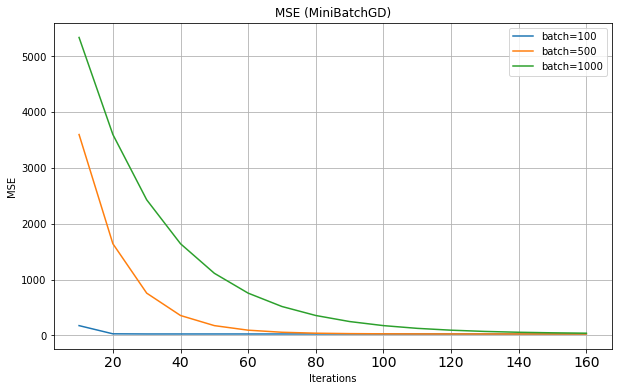

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(iter_arr_2, mse_mbgd_arr_100, label='batch=100')
plt.plot(iter_arr_2, mse_mbgd_arr_500, label='batch=500')
plt.plot(iter_arr_2, mse_mbgd_arr_1000, label='batch=1000')
plt.title('MSE (MiniBatchGD)')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.grid()
plt.show()

Что касается алгоритма MiniBatchGD, здесь сравниваем условные скорости сходимости при разных гиперпараметрах `batch`. Естественно при уменьшении `batch` для приближения ошибки к минимальной требуется всё меньше итераций.

In [13]:
%%time

eval_gd(X_, y_, iters=1800, alpha=2e-3, random_state=23, verbose=True)

180 [43.40196305 15.867366  ] 1915.3107822372294
360 [64.34824085 23.53883013] 477.6417607541539
540 [74.61476009 27.25427856] 133.23080134189243
720 [79.64666835 29.05396446] 50.71823029288712
900 [82.1129092  29.92580025] 30.94910883449873
1080 [83.32164588 30.34820149] 26.212388602936453
1260 [83.91405467 30.55287808] 25.077403207030525
1440 [84.20439344 30.65206711] 24.805431277715574
1620 [84.34668609 30.70014125] 24.740256690264143
1800 [84.41642158 30.72344424] 24.72463773202584
Wall time: 589 ms


array([84.41642158, 30.72344424])

In [14]:
%%time

eval_sgd(X_, y_, iters=1800, alpha=2e-3, random_state=23, verbose=True)

180 [39.30162479 14.4359056 ] 2309.787461277884
360 [60.96782622 24.77827429] 607.1764417368147
540 [74.10140592 27.29499551] 143.22355331865012
720 [79.11668642 29.10183889] 55.904130318723546
900 [81.90104224 30.06121075] 31.782585170266067
1080 [83.00631382 30.88989809] 26.903865307549374
1260 [83.69440843 30.92330643] 25.369925259395448
1440 [83.92490576 31.30034897] 25.345632696422474
1620 [84.42879056 31.15457009] 24.893511013715848
1800 [84.41965605 30.92594071] 24.757082131048968
Wall time: 321 ms


array([84.41965605, 30.92594071])

In [15]:
%%time

eval_mbgd(X_, y_, iters=100, alpha=2e-3, batch=500, random_state=23, verbose=True)

10 [46.53162937 17.01978686] 1637.7013702463425
20 [67.29939792 24.61225427] 354.3924493965641
30 [76.70297282 28.00487808] 92.10188361346113
40 [80.96079661 29.52106689] 38.49141724228913
50 [82.8886506  30.19876409] 27.53389522119168
60 [83.76152663 30.50172242] 25.294505923972615
70 [84.15673229 30.63717738] 24.836983905487017
80 [84.33566352 30.69774934] 24.743580120869673
90 [84.41667409 30.7248396 ] 24.72454490452084
100 [84.45335077 30.73695727] 24.720680878957523
Wall time: 112 ms


array([84.45335077, 30.73695727])

In [16]:
coef, calc_mse(y_, np.dot(X_, coef))

(array([84.46900527, 30.73205568]), 24.72009979752069)

По итогу сравнения алгоритмов при условии $\alpha=2\cdot10^{-3}$ и достижении mse, близкой к минимальной, самым быстрым оказался MiniBatchGD c `batch=500`(1/20 датасета) и `iters=100` (около 95 мс), далее - StochasticGD c `iters=1800` (около 210 мс) ,и медленне остальных - GD c `iters=1800` (около 360 мс).
___

### Задание №2.
Добавить в алгоритм градиентного спуска L1 регуляризацию. Сравнить влияние коэффициентов регуляризации L1 и L2 на величину весов для примера из урока (лучше графически).

In [17]:
def std_scale(x):
    return (x - x.mean()) / x.std()

In [18]:
def eval_gd_reg1(X, y, iters=1000, alpha=1e-3, lambda_=1e-8, random_state=None, verbose=False):
    if random_state:
        np.random.seed(random_state)
    
    w = np.random.randn(X.shape[1])
    y_pred = np.dot(X, w)
    n = X.shape[0]
    
    for i in range(1, iters + 1):
        w -= alpha * (2 * np.dot(X.T, y_pred - y) / n + lambda_ * np.sign(w))
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        
        if verbose and i % (iters / 10) == 0:
            print(i, w, err)
    
    return w

In [19]:
def eval_gd_reg2(X, y, iters=1000, alpha=1e-3, lambda_=1e-8, random_state=None, verbose=False):
    if random_state:
        np.random.seed(random_state)
    
    w = np.random.randn(X.shape[1])
    y_pred = np.dot(X, w)
    n = X.shape[0]
    
    for i in range(1, iters + 1):
        w -= alpha * (2 * np.dot(X.T, y_pred - y) / n + 2 * lambda_ * w)
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        
        if verbose and i % (iters / 10) == 0:
            print(i, w, err)
    
    return w

In [20]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]]).T
               
y = [45, 55, 50, 59, 65, 35, 75, 80, 50, 60]

In [21]:
X_st = X.copy().astype(np.float64)
for i in range(1, 4):
    X_st[:, i] = std_scale(X[:, i])

#### L1 регуляризация.

In [22]:
l_1_arr = np.logspace(-3, 2, 20)
w_1_arr = np.array([eval_gd_reg1(X_st, y, alpha=1e-3, lambda_=l, random_state=23) for l in l_1_arr])
err_1_arr = np.array([calc_mse(y, np.dot(X_st, eval_gd_reg1(X_st, y, alpha=1e-2, lambda_=l, random_state=23))) for l in l_1_arr])

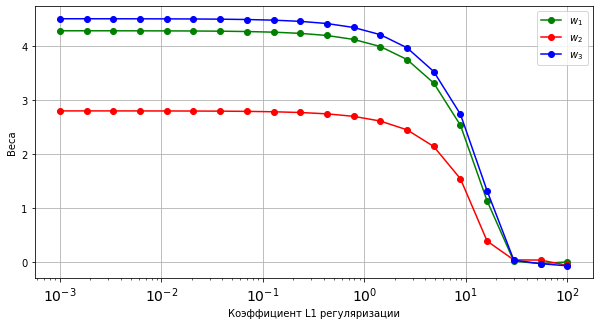

In [23]:
plt.figure(figsize=(10, 5))
plt.xscale('log')
plt.plot(l_1_arr, w_1_arr[:, 1], 'go-', label=r'$w_1$')
plt.plot(l_1_arr, w_1_arr[:, 2], 'ro-', label=r'$w_2$')
plt.plot(l_1_arr, w_1_arr[:, 3], 'bo-', label=r'$w_3$')
plt.xlabel('Коэффициент L1 регуляризации')
plt.ylabel('Веса')
plt.grid()
plt.legend()

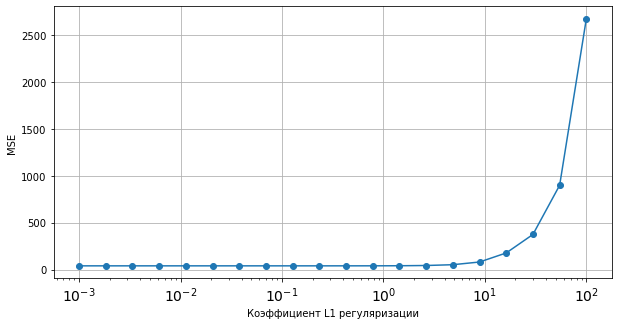

In [24]:
plt.figure(figsize=(10, 5))
plt.xscale('log')
plt.plot(l_1_arr, err_1_arr, 'o-')
plt.xlabel('Коэффициент L1 регуляризации')
plt.ylabel('MSE')
plt.grid();

#### L2 регуляризация.

In [25]:
l_2_arr = np.logspace(-4, 1, 20)
w_2_arr = np.array([eval_gd_reg2(X_st, y, alpha=1e-2, lambda_=l, random_state=23) for l in l_2_arr])
err_2_arr = np.array([calc_mse(y, np.dot(X_st, eval_gd_reg2(X_st, y, alpha=1e-2, lambda_=l, random_state=23))) for l in l_2_arr])

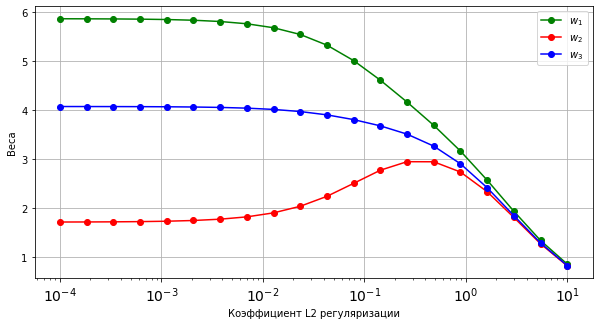

In [26]:
plt.figure(figsize=(10, 5))
plt.xscale('log')
plt.plot(l_2_arr, w_2_arr[:, 1], 'go-', label=r'$w_1$')
plt.plot(l_2_arr, w_2_arr[:, 2], 'ro-', label=r'$w_2$')
plt.plot(l_2_arr, w_2_arr[:, 3], 'bo-', label=r'$w_3$')
plt.xlabel('Коэффициент L2 регуляризации')
plt.ylabel('Веса')
plt.grid()
plt.legend()

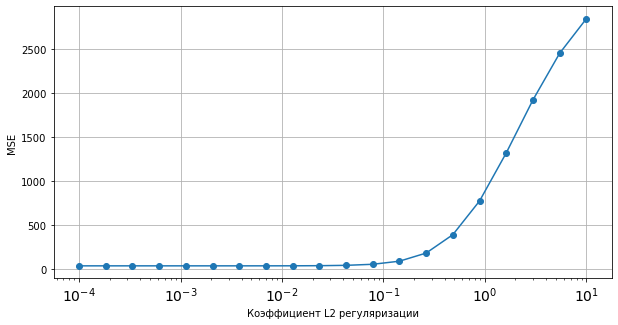

In [27]:
plt.figure(figsize=(10, 5))
plt.xscale('log')
plt.plot(l_2_arr, err_2_arr, 'o-')
plt.xlabel('Коэффициент L2 регуляризации')
plt.ylabel('MSE')
plt.grid();